In this notebook we simulate future stock prices, risk-free rates, 3 year bonds and sharpe ratios from 31 october 2014 to 31 october 2033. We assume that the voatility follows stockastic process (Heston Model). We assume that other 

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import market_stochastic_simulation as mss
import retirement_client as pensioner

# 1. Market Simulation Code

$
\begin{cases}
r_{t+dt} = r_t + \kappa_r (\bar{lt_r} - r_t) dt + \sigma_r \sqrt{dt} Z_t^r\\
SR_{t+dt} = SR_t + \kappa_sr (\bar{lt_sr} - SR_t) dt + \sigma_SR \sqrt{dt} Z_t^SR\\
V_{t+dt} = V_t + \kappa_v (lt_V - V_t) dt + \sigma_V \sqrt{V_t} \sqrt{dt} Z_t^V\\
S_{t+dt} = S_t \times \exp \left( \left( r + \bar{\lambda_0} \sigma_t - \frac{1}{2} \sigma_t^2 \right) dt + \sigma_t \sqrt{dt} Z_t^S \right) \\
\end{cases}
$

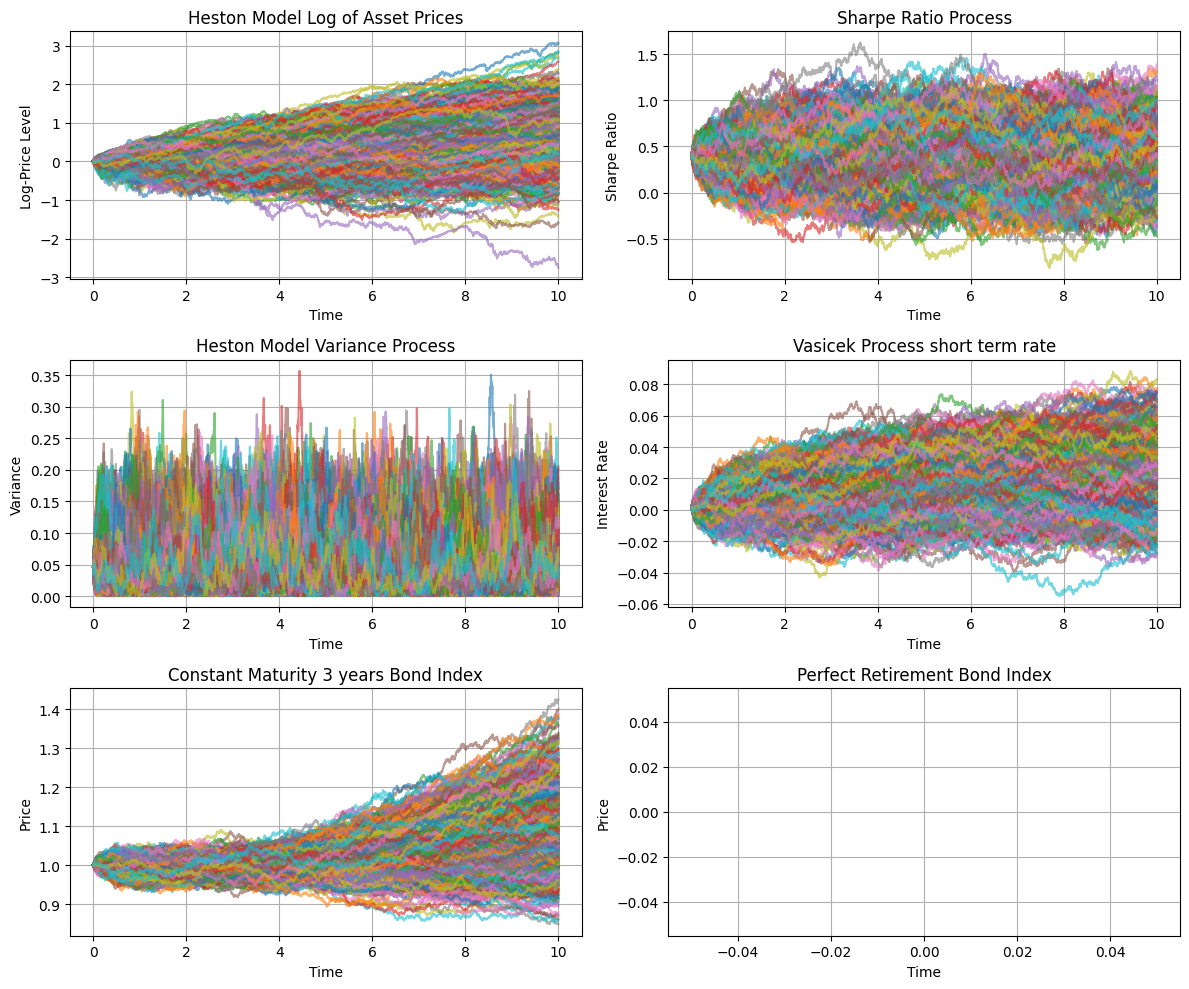

In [2]:
# Parameters
S0 = 1.0              # asset price
T = 10                  # time in years
N = 252*T              # number of time steps in simulation
M = 1000                # number of simulated paths
seed = 123              # simulation seed

simulated_market = mss.MarketSimulator(T,N,M,seed, S0)
simulated_market.plot_market_simulation()

## Initialize client

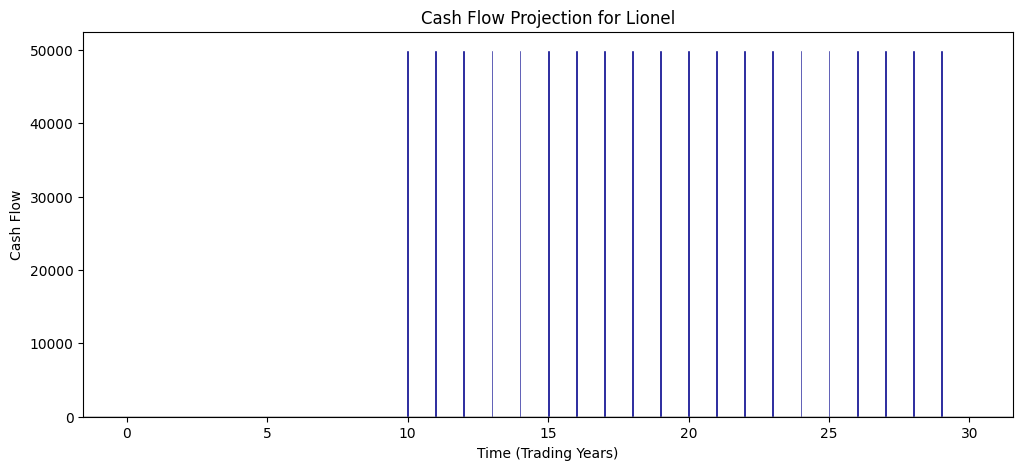

In [3]:
client = pensioner.RetirementClient("Lionel",
                           accumulation_years=10,
                           accumulation_cash_flow=0,
                           decumulation_years=20,
                           decumulation_cash_flow=50000,
                           periodicity = 12)

client.plot_cash_flows()

Now we know cash flows that the client needs. Hence, we can simulate perfect retirement bond for him

In [4]:
simulated_market.calculate_perfect_retirement_bond(client)

Simulating scenarios: 100%|█████████████████| 1000/1000 [02:00<00:00,  8.30it/s]
/Users/aleksandrmikhailov/Desktop/GitHub_EDHEC/Retirement solution/Goal-Based-Investing/market_stochastic_simulation.py:295: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  retirement_bond_p.loc[:, simulation_number] = result[i]


Plot the market and the retirement bond index. If you would use M = 31, you would get full retirement bond price with ladder

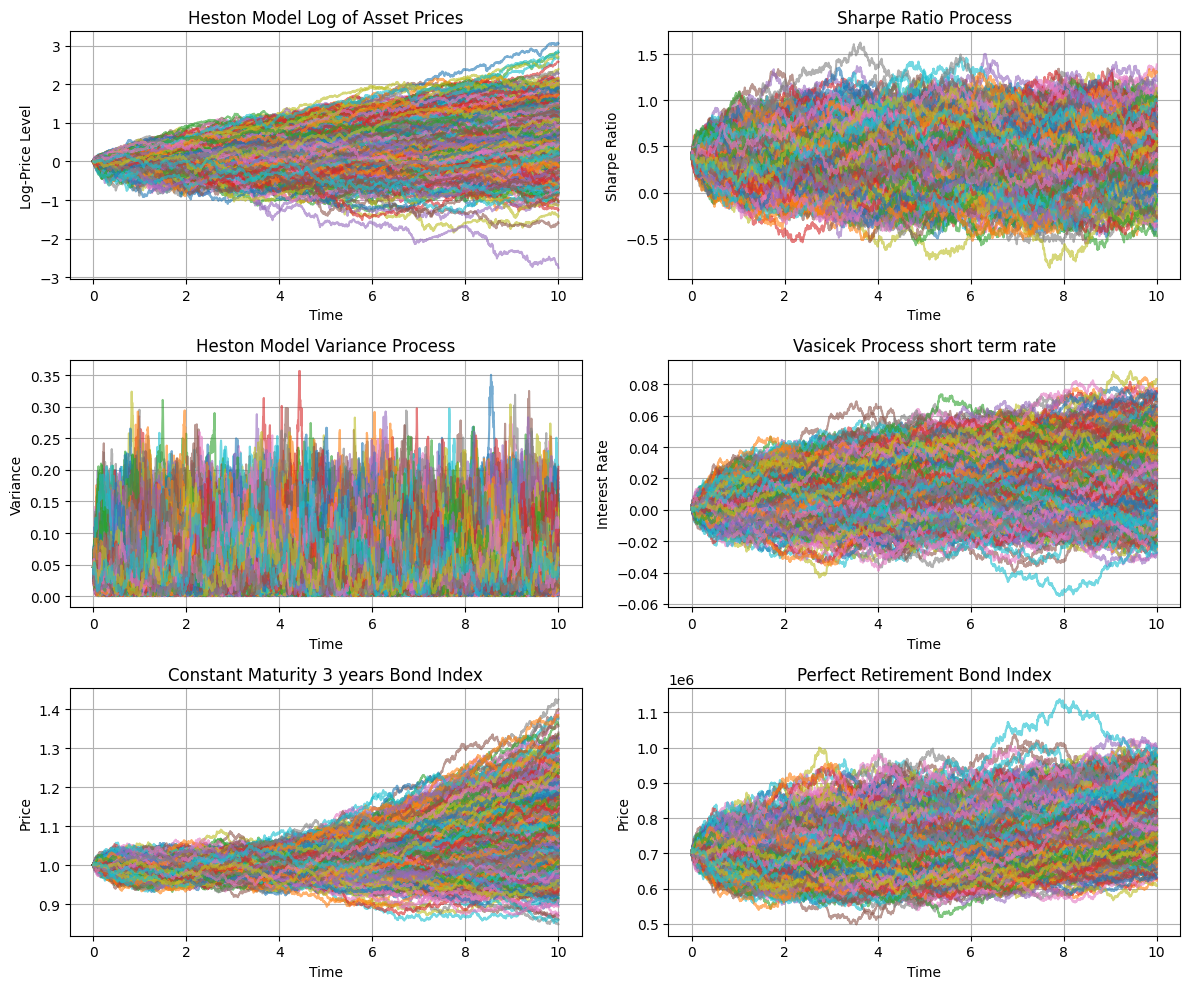

In [5]:
simulated_market.plot_market_simulation()

## Set up a fund

In [6]:
class FundAllocationSimulator:
    def __init__(self, initial_savings, retirement_bond_p, r_p):
        """
        Initializes the FundAllocationSimulator class with initial savings, 
        retirement bond price data, and short-term interest rates.
        
        Parameters:
        - initial_savings (float): The initial amount invested by the individual.
        - retirement_bond_p (DataFrame): The retirement bond price data (simulated).
        - r_p (DataFrame): The short-term interest rates for the simulations.
        """
        self.initial_savings = initial_savings
        self.retirement_bond_p = retirement_bond_p
        self.r_p = r_p
        
        # Calculate the percentage change of the retirement bond price to get RL (Retirement Liability)
        self.RL = self.retirement_bond_p.pct_change().dropna()

        # Drop the first observation of r_p to match the alignment after pct_change
        self.r_p = self.r_p.drop(self.r_p.index[0])
        
        # Initialize an empty results DataFrame
        self.results_df = pd.DataFrame(columns = ['simulation_M',
                                                  'x',
                                                  'rebalance_each_X_periods',
                                                  'annualized_variance',
                                                  'total_return',
                                                  'annualized_return',
                                                  'annualized_sharpe_ratio',
                                                  'annualized_tracking_err'])
        
    def balanced_fund(self, PSP, GHP, x, rebalance_each_X_periods):
        """
        Simulates a portfolio with a mix of two assets, PSP and GHP, based on an investment weight x.
        
        Parameters:
        - PSP: DataFrame of asset prices (e.g., stock prices).
        - GHP: DataFrame of asset prices (e.g., bond prices).
        - x: Float (0 <= x <= 1) representing the weight for PSP. The remaining weight is allocated to GHP.
             It does not have restriction to be less than 0 or higher than 1 in code, so maybe this can happen
             If it happens there will be alert raised
        - rebalance_each_X_periods: int or str, Frequency at which to rebalance the portfolio
            If parameter = 2, for instance, rebalancing weill be done every other period (trading days, for instance)
            If parameter = 21, rebalancing will be done every 21st period (every 21st day if we have days)
            If parameter = "no_rebalancing", there is NO REBALANCING
            
        Returns:
        - DataFrame containing the portfolio weights of PSP over time.
        - DataFrame containing the total portfolio returns (of PSP and GHP)
        - DataFrame containing the weight changes for transaction costs
        """
        
        # Step 1: Calculate returns for PSP and GHP
        psp_returns = PSP.pct_change()  # Percentage change of the index price, leave NaNs
        ghp_returns = GHP.pct_change()  # Percentage change of the index price, leave NaNs
        
        # Step 2: Create a DataFrame to hold the PSP weights in portfolio
        psp_weights = pd.DataFrame(index=PSP.index, columns=PSP.columns)
        
        # Step 3: Create a DataFrame to hold the portfolio returns over time
        portfolio_returns = pd.DataFrame(index=PSP.index, columns=PSP.columns)
        
        # Step 4: Create a DataFrame to hold the weight values at rebalancing dates
        weight_change_for_tr_costs_psp = pd.DataFrame(index=PSP.index, columns=PSP.columns).fillna(0)
        
        # Step 5: Portfolio simulation
        # Weights are initially set to x for PSP
        # All weights for the first time step are based on x (1-x for GHP)
        psp_weights.iloc[0, :] = x
        periods_till_rebalancing = rebalance_each_X_periods
        
        for i in range(1, len(PSP)):
            portfolio_returns.iloc[i,:] = psp_weights.iloc[i-1, :] * psp_returns.iloc[i,:] + \
            (1 - psp_weights.iloc[i-1, :]) * ghp_returns.iloc[i,:]
        
            # find new value for PSP and GHP that are based on the returns
            PSP_new_value = x * (1 + psp_returns.iloc[i,:])
            GHP_new_value = (1 - x) * (1 + ghp_returns.iloc[i,:])
            # find total new value of portfolio
            total_portfolio_new_value = PSP_new_value + GHP_new_value
        
            # new drifted weight of PSP is the value of the PSP in total portfolio value
            psp_new_weight = PSP_new_value / total_portfolio_new_value
        
            if rebalance_each_X_periods != "no_rebalancing":
                # if there is rebalancing and it is date of rebalancing today
                periods_till_rebalancing -=1
                
                if periods_till_rebalancing == 0:
        
                    # then we need to store the change in weights for transaction costs modeling
                    weight_change_for_tr_costs_psp.iloc[i,:] = x - psp_new_weight
        
                    # and put instead of the calculated weights for the new period weights at rebalancing date
                    psp_weights.iloc[i, :] = x
        
                    # reset preiods_till_rebalancing to initial value
                    periods_till_rebalancing = rebalance_each_X_periods
                    
                else:
                    # otherwise, if it is not rabalancing date today just update the weights
                    psp_weights.iloc[i, :] = psp_new_weight
            else:
                # otherwise, if we do not rebalance at all, just update the weights
                psp_weights.iloc[i, :] = psp_new_weight
            
            # Note that in this code return_portfolio = return_assets_t+1*w_t
            # It assures out-of-sample calculation
                
            # Also note that w_t+1 is found using returns of the new period. 
            # It is correct to drift weights like that.
        
            # Finally note that at rebalancing date T there are 2 weights:
            # weight w_T that has drifted from the previous period and 
            # weight w_T = x (initial weight in balanced fund).
            # I save only w_T = x in weights_psp for correctness of portfolio
            # returns calculation
            # I also save x-psp_new_weight to know what was the move for rebalancing: buy / sell and how much
    
        # psp_weights will Have no NaN values
        # portfolio_returns will have 1st row of NaNs
        # to find portfolio_returns artificially do psp_weights.shift(1)*psp_return + (1-psp_weights.shift(1))*hgp_return 
        return portfolio_returns, psp_weights, weight_change_for_tr_costs_psp

    def tracking_error(self, fund_returns, periods_in_year):
        """
        Calculate the tracking error between the fund's returns and the retirement liability (RL).
        
        Parameters:
        - fund_returns (DataFrame): The returns of the balanced fund
        
        Returns:
        - tracking_error (float): The tracking error of the portfolio
        """
        return np.var(fund_returns - self.RL) * periods_in_year

    def sharpe_ratio(self, fund_returns, periods_in_year):
        """
        Calculate the Sharpe ratio of the portfolio.
        
        Parameters:
        - fund_returns (DataFrame): The returns of the balanced fund
        
        Returns:
        - sharpe_ratio (float): The Sharpe ratio of the portfolio
        """
        # Risk-free rate should be on "period level" (on daily self.r_p/252)
        risk_free = self.r_p / periods_in_year
        return (np.mean(fund_returns) - np.mean(risk_free)) / np.std(fund_returns) * np.sqrt(periods_in_year)

    def run_simulation(self, PSP, GHP, x_options, rebalancing_options, periods_in_year):
        """
        Runs multiple simulations for different x values and rebalance frequencies.
        
        Parameters:
        - PSP (DataFrame): The dataset containing the asset prices of the PSP over time.
        - GHP (DataFrame): The dataset containing the asset prices of the GHP over time.
        - x_options (array): A series of values representing the different weights to invest in PSP.
        - rebalance_options (array): A series of rebalance frequencies to test (each Nth period will be done rebalancing)
        - periods_in_year is how many periods are in each year in PSP and GHP. For example, for yearly observations put 1
                                                                               for monthly 12, for daily 252
        
        Returns:
        - self.results_df (DataFrame): A DataFrame containing results for each simulation scenario.
        """

        # number of market pre-simulated scenarios
        # in code related to market simulation this is called M
        number_of_simulations = len(PSP.columns)
        
        for x in tqdm(x_options):
            for rebalance_each_X_periods in rebalancing_options:
                # Run the balanced fund simulation
                returns_of_fund, _, _ = self.balanced_fund(PSP, GHP, x, rebalance_each_X_periods)
                
                # Calculate annualized return
                total_return = (returns_of_fund+1).prod()-1
                annualized_return = (1 + total_return) ** (1 / (len(returns_of_fund) / periods_in_year)) - 1
                
                # Calculate variance of fund return (annualized)
                annualized_variance = np.var(returns_of_fund) * periods_in_year  # Annualized variance
                
                # Calculate Sharpe ratio
                annualized_sharpe_ratio = self.sharpe_ratio(returns_of_fund, periods_in_year)
                
                # Calculate tracking error
                annualized_tracking_err = self.tracking_error(returns_of_fund, periods_in_year)
        
                # Store the results in the dataframe
                rebalance_each_X_periods = np.repeat(rebalance_each_X_periods, number_of_simulations)
                
                new_results_to_store = pd.DataFrame({
                                                    'simulation_M': PSP.columns,
                                                    'x': np.repeat(x, number_of_simulations),
                                                    'rebalance_each_X_periods': rebalance_each_X_periods,
                                                    'annualized_variance': annualized_variance,
                                                    'total_return':total_return,
                                                    'annualized_return': annualized_return,
                                                    'annualized_sharpe_ratio': annualized_sharpe_ratio,
                                                    'annualized_tracking_err': annualized_tracking_err
                                                    })
                # update global dataframe                                        
                self.results_df = pd.concat([self.results_df, new_results_to_store], ignore_index=True)

In [7]:
fund_allocation_simulator = FundAllocationSimulator(initial_savings = 287000,
                                                    retirement_bond_p = simulated_market.retirement_bond_p,
                                                    r_p = simulated_market.r_p)

In [8]:
# To the function; or to generate results for 1 balanced fund
returns_of_fund, weights_of_assets, _ = fund_allocation_simulator.balanced_fund(PSP = simulated_market.S_p,
                                                                               GHP = simulated_market.B_p, 
                                                                               x = 0.5, 
                                                                               rebalance_each_X_periods = 'no_rebalancing')

In [9]:
fund_allocation_simulator.run_simulation(PSP = simulated_market.S_p,
                                           GHP = simulated_market.B_p, 
                                           x_options= [0.2,0.5,0.8], 
                                           rebalancing_options= ['no_rebalancing',21], # no rebalancing vs each 21 day rebalancing
                                           periods_in_year = int(simulated_market.N / simulated_market.T)
                                        )

100%|█████████████████████████████████████████████| 3/3 [00:24<00:00,  8.33s/it]


In [10]:
fund_allocation_simulator.results_df

,simulation_M,x,rebalance_each_X_periods,annualized_variance,total_return,annualized_return,annualized_sharpe_ratio,annualized_tracking_err
0,0,0.2,no_rebalancing,0.002562,0.365993,0.031667,0.254252,0.003528
1,1,0.2,no_rebalancing,0.002013,0.21205,0.01941,0.286826,0.002971
2,2,0.2,no_rebalancing,0.002418,-0.166463,-0.018036,0.261726,0.003507
3,3,0.2,no_rebalancing,0.002511,0.297633,0.026386,0.256846,0.00355
4,4,0.2,no_rebalancing,0.002321,0.533968,0.043697,0.267134,0.003364
...,...,...,...,...,...,...,...,...
5995,995,0.8,21,0.025819,1.947358,0.114101,0.411841,0.028736
5996,996,0.8,21,0.028722,0.52524,0.043101,0.390469,0.031827
5997,997,0.8,21,0.026368,0.098216,0.009409,0.407528,0.029152
5998,998,0.8,21,0.032818,1.661187,0.102785,0.365291,0.035941


In [11]:
def plot_tracking_error_histograms_separate(df):
    """
    Plots separate histograms of tracking errors and total returns for each rebalance frequency.
    
    Parameters:
    - df (DataFrame): The dataframe containing the simulation results.
    """
    
    # Get unique values of rebalance_each_X_periods
    rebalance_options = list(df['rebalance_each_X_periods'].unique())
    
    # Loop through each rebalance option
    for rebalance in rebalance_options:
        # Filter the data for the current rebalance option
        filtered_data = df[df['rebalance_each_X_periods'] == rebalance]
        
        # Create subplots: 1 row, 2 columns (one for tracking error and one for total return)
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Define a color palette for 'x' values
        colors = sns.color_palette("Set1", n_colors=len(filtered_data['x'].unique()))
        
        # Plot histograms for Tracking Error
        for idx, x in enumerate(sorted(fund_allocation_simulator.results_df['x'].unique())[::-1]):
            x_data = filtered_data[filtered_data['x'] == x]
            sns.histplot(x_data['annualized_tracking_err'], kde=True, bins=20, label=f"x = {x}", ax=axes[0], color=colors[idx])
        
        axes[0].set_title(f"Tracking Error Distribution for Rebalance Periods={rebalance}")
        axes[0].set_xlabel("Annualized Tracking Error")
        axes[0].set_ylabel("Frequency")
        axes[0].legend(title="x Value")
        axes[0].grid(True)

        # Plot histograms for Total Return
        for idx, x in enumerate(sorted(fund_allocation_simulator.results_df['x'].unique())[::-1]):
            x_data = filtered_data[filtered_data['x'] == x]
            sns.histplot(x_data['total_return'], kde=True, bins=20, label=f"x = {x}", ax=axes[1], color=colors[idx])

            # Add a vertical line for the mean of total return on the second plot
            mean_total_return = x_data['total_return'].mean()
            axes[1].axvline(mean_total_return, linestyle='dashed', linewidth=2, color=colors[idx], label=f"Mean of {x} TR: {mean_total_return:.2f}")
        
        axes[1].set_title(f"Total Return Distribution for Rebalance Periods={rebalance}")
        axes[1].set_xlabel("Total Return")
        axes[1].set_ylabel("Frequency")
        axes[1].legend(title="x Value")
        axes[1].grid(True)
        axes[1].set_xlim(-1, 5)

        # Show the plots
        plt.tight_layout()
        plt.show()


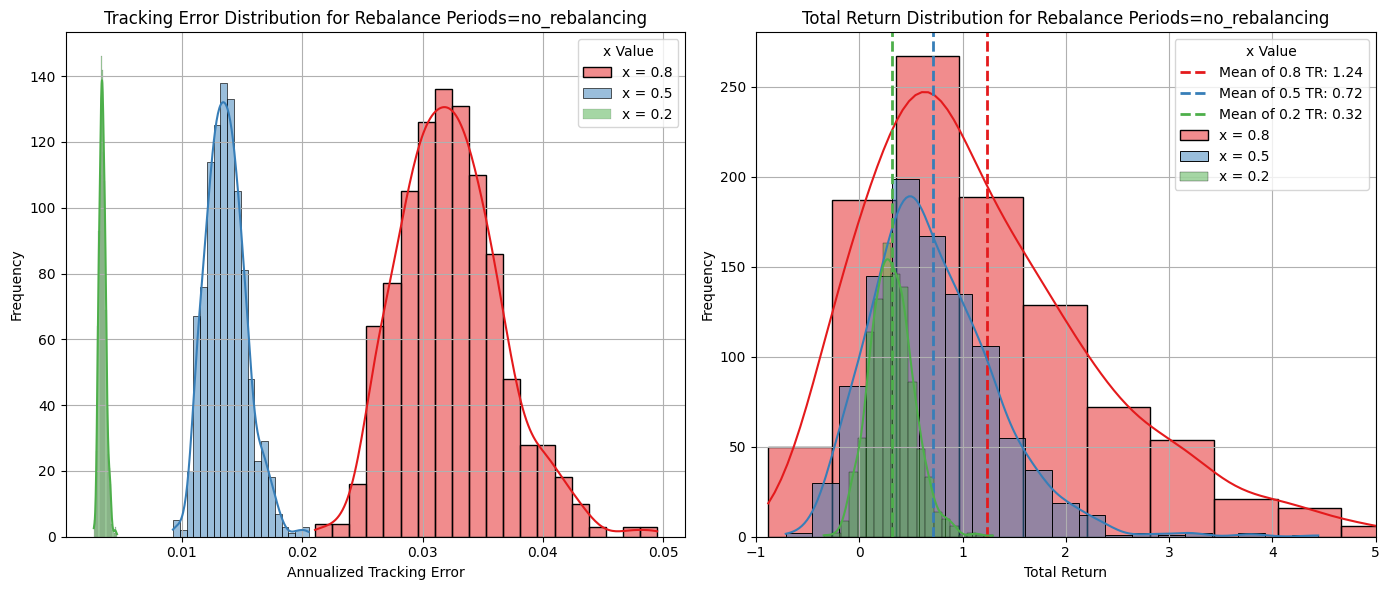

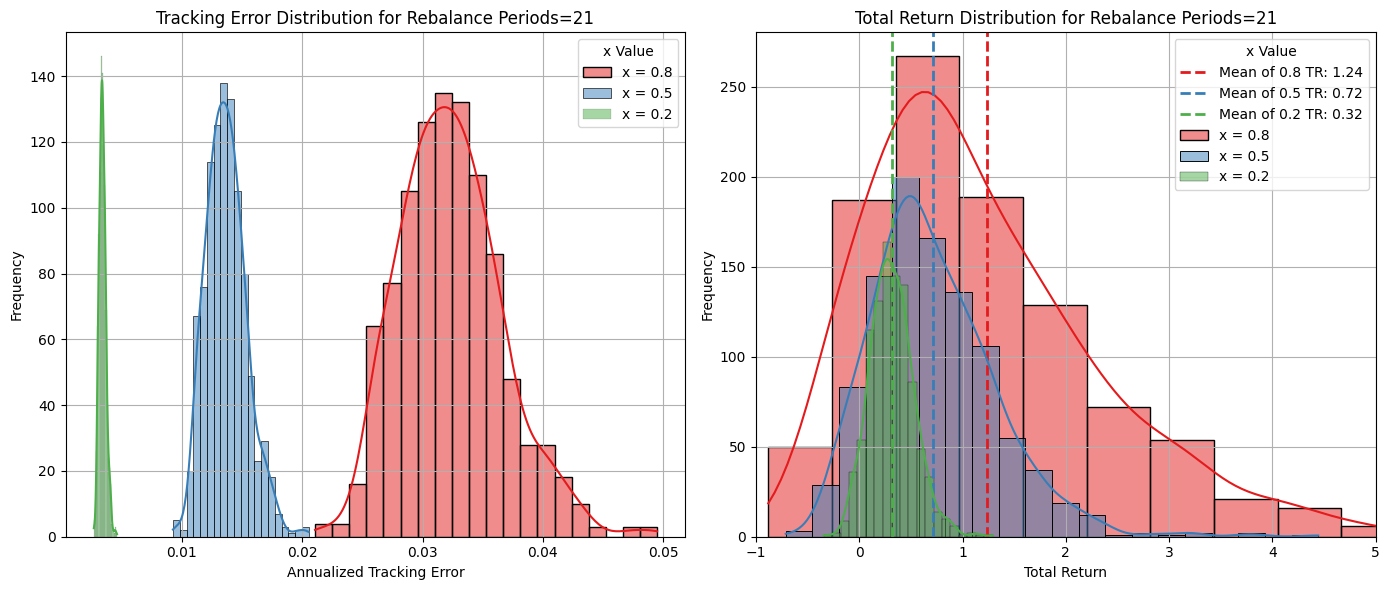

In [12]:
plot_tracking_error_histograms_separate(fund_allocation_simulator.results_df)

Results are wrong. Fund without rebalancing should behave worse